In [289]:
import numpy as np
import pandas as pd
import string

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

from nltk.corpus import stopwords
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [290]:
data = pd.read_csv('../05_machine_learning/clean_data.csv', ';')
data.head()

,name,cod,words
0,03000000012017_6622932_inicial_lorena.pdf,5070,DA NECESSIDADE E TITULAR DA DA PRETERIÇÃO EM ...
1,03000001632017_6667276_inicial_valquiria.pdf,5070,acionada que O direito que assiste Indenização...
2,02001000312017_6699679_20160112_MANDADO_DE_CIT...,5070,e que pendem Regiao - e Trabalhasta e quitados...
3,02000000182017_6739022_RT_00009552320165110201...,5070,próprio e o DA MULTA o que o fez DA COMPETÊNCI...
4,02000000222017_6758570_PETICAO_INICIAL__ROGERI...,5070,que quebra caixa não caixa que eram caixa para...


In [291]:
con = ' '.join(data.name)\
         .translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))\
         .lower()

con

'03000000012017 6622932 inicial lorena pdf 03000001632017 6667276 inicial valquiria pdf 02001000312017 6699679 20160112 mandado de citacao pdf 02000000182017 6739022 rt 00009552320165110201 dayana de souza carvalho pdf 02000000222017 6758570 peticao inicial  rogerio pessoa de melo pdf 02000000212017 6758941 peticao inicial renata pdf 02000000302017 6761978 mandado de intimacao   proc 16374 70 2016 4 01 3200 pdf 02001000322017 6773442 peticao inicial np00051123320164014200gr1 zip 02001000562017 6773444 1 peticao np00064772520164014200gr1 zip 02001000562017 6773445 2 peticao np00064772520164014200gr1 zip 02001000572017 6773446 peticao np00059784120164014200gr1 zip 02001000582017 6773447 peticao np00064755520164014200gr1 zip 02001000592017 6773448 peticao np00063248920164014200gr1 zip 02001000602017 6773449 peticao np00063802520164014200gr1 zip 02001000612017 6773450 peticao np00058753420164014200gr1 zip 02001000652017 6773454 peticao np00058675720164014200gr1 zip 02001000662017 6773455 p

In [292]:
count = {}
for word in con.split():
    if word in count:
        count[word] += 1
    else:
        count[word] = 0

pd.Series(count).sort_values(ascending=False).head(20)

pdf               581
documento         477
02001001452017     68
02001001442017     62
02001001412017     62
02001001422017     61
02001001432017     59
peticao            47
2017               40
inicial            39
02001001402017     33
4                  31
8                  31
02001001492017     31
02001001382017     26
02001001372017     26
02001002112017     24
5                  23
02001001392017     23
11                 22
dtype: int64

In [293]:
groups = {'documento':set(), 'peticao':set()}
outros = set()
#peticao, outros = set(), set()
for i in data.name:
    ok = False
    for g in groups.keys():
        if g in i.lower():
            groups[g].add(i)
            ok = True
            break
    
    if not ok:
        outros.add(i)

In [294]:
def classify(row, groups):
    ok = False
    for g in groups.keys():
        if g in row['name'].lower():
            return g
    
    return 'outros'

data['label'] = data.apply(lambda x: classify(x, groups), axis=1)
data.label.value_counts()

documento    478
outros        72
peticao       49
Name: label, dtype: int64

In [295]:
data.set_index('name', inplace=True)
data.drop('cod', axis=1, inplace=True)
data.head()

,words,label
name,,
03000000012017_6622932_inicial_lorena.pdf,DA NECESSIDADE E TITULAR DA DA PRETERIÇÃO EM ...,outros
03000001632017_6667276_inicial_valquiria.pdf,acionada que O direito que assiste Indenização...,outros
02001000312017_6699679_20160112_MANDADO_DE_CITACAO.pdf,e que pendem Regiao - e Trabalhasta e quitados...,outros
02000000182017_6739022_RT_00009552320165110201_DAYANA_DE_SOUZA_CARVALHO.pdf,próprio e o DA MULTA o que o fez DA COMPETÊNCI...,outros
02000000222017_6758570_PETICAO_INICIAL__ROGERIO_PESSOA_DE_MELO.pdf,que quebra caixa não caixa que eram caixa para...,peticao


In [296]:
words = data.words
label = data.label

In [297]:
vec = TfidfVectorizer(stop_words=stopwords.words('portuguese'), max_df=.8)
words = vec.fit_transform(words)
words.shape

(599, 46310)

In [298]:
svd = TruncatedSVD()
words = svd.fit_transform(words)
words.shape

(599, 2)

In [299]:
words = Normalizer().fit_transform(words)
stats.describe(words)

DescribeResult(nobs=599, minmax=(array([ 0.28530245, -0.34790008]), array([0.99999681, 0.95843754])), mean=array([0.79971852, 0.38271868]), variance=array([0.04219279, 0.17214173]), skewness=array([-1.15403165, -0.42044624]), kurtosis=array([ 0.33974556, -1.14804697]))

In [300]:
x, y = [], []
for i in range(len(words)):
    x.append(words[i][0])
    y.append(words[i][1])

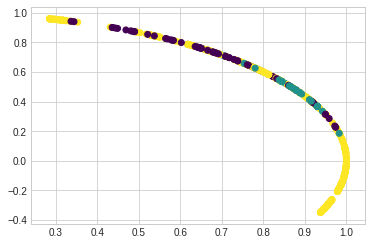

In [301]:
plt.scatter(x, y, c=pd.factorize(label)[0], cmap='viridis', alpha=1)

In [302]:
cls = KMeans(n_clusters=3, n_init=10, random_state=0).fit(words)
predictions = cls.predict(words)
print('Clusters:')
print(pd.Series(cls.labels_).value_counts())

Clusters:
2    246
1    180
0    173
dtype: int64


In [303]:
d = dict(zip(data.label.value_counts().index, np.unique(cls.labels_)))
label = pd.Series(label.map(d))
label.value_counts()

0    478
1     72
2     49
Name: label, dtype: int64

In [304]:
original_centroids = svd.inverse_transform(cls.cluster_centers_)
centroids = original_centroids.argsort()[:, ::-1]
for i in range(len(label.value_counts())):
    print('Cluster', list(d.keys())[i]),
    for j in centroids[i, :10]:
        print(vec.get_feature_names()[j]),
    print('\n')

Cluster documento
paragrafo
nao
empregado
sera
empregados
ser
serao
horas
pagamento
primeiro


Cluster outros
concurso
público
direito
aprovados
reclamante
nomeação
reclamada
contratação
candidatos
cargo


Cluster peticao
paragrafo
concurso
empregado
nao
público
ser
reclamante
direito
empregados
sera




In [305]:
print(metrics.classification_report(label, predictions))
print(metrics.confusion_matrix(label, predictions))

             precision    recall  f1-score   support

          0       0.72      0.26      0.38       478
          1       0.01      0.01      0.01        72
          2       0.17      0.86      0.28        49

avg / total       0.59      0.28      0.33       599

[[124 178 176]
 [ 43   1  28]
 [  6   1  42]]


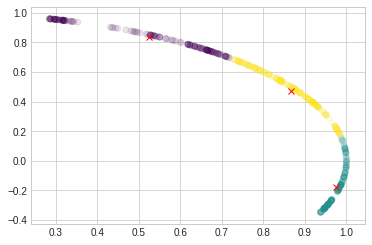

In [306]:
plt.scatter(x, y, c=cls.labels_, cmap='viridis', alpha=.1)
for i in cls.cluster_centers_:
    plt.plot(i[0], i[1], 'x', color='red')